In [1]:
import numpy as np
import scipy
from scipy.misc import imread
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from skimage import filters as skifilters
from sklearn.ensemble import RandomForestClassifier
import h5py
import skimage.feature
import scipy.ndimage.filters as scifilters

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load data

In [6]:
hdf5_path = "\\Users\carolina.cuesta-laza\Desktop\\"
filename = 'dataset.hdf5'
#filename = 'test.hdf5'

In [7]:
dataset = h5py.File(hdf5_path + filename, 'r')

In [8]:
print(dataset['train_label'].shape)

(15, 200, 200, 3)


### Make sure they look fine

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


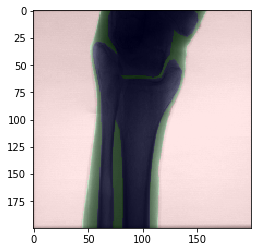

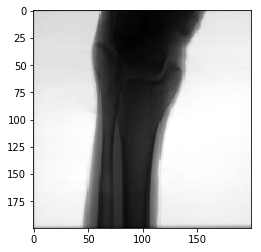

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


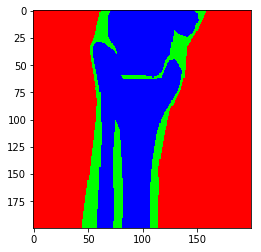

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


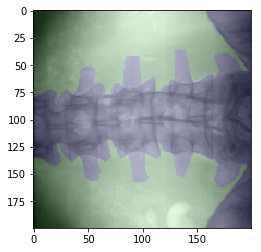

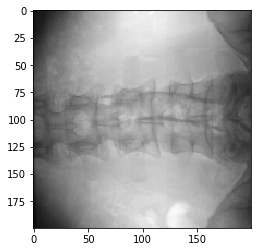

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


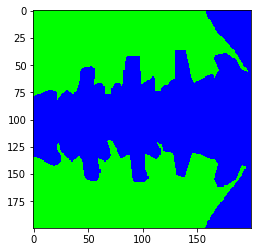

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


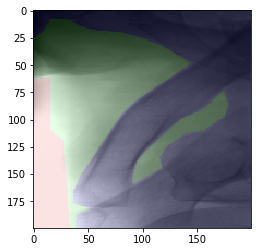

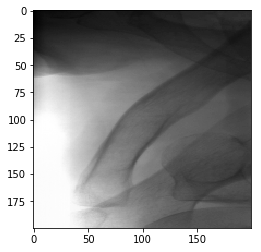

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


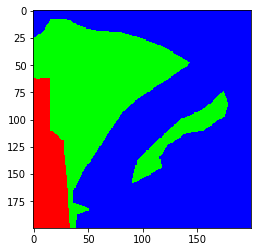

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


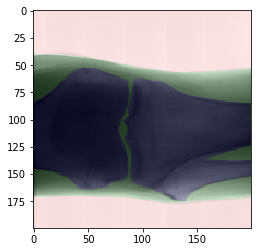

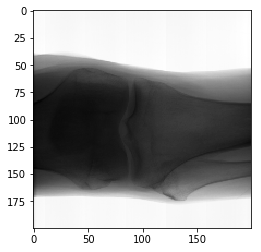

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


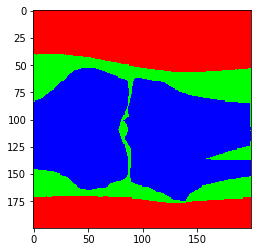

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


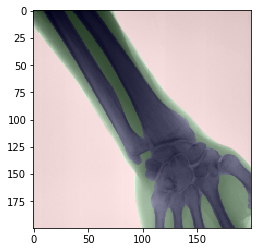

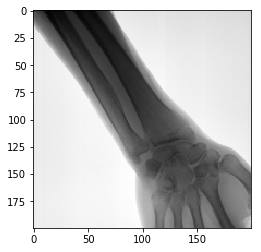

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


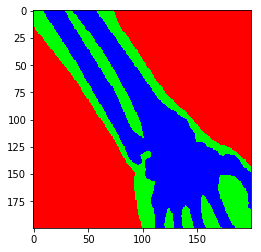

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


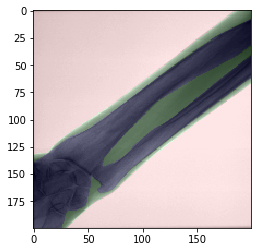

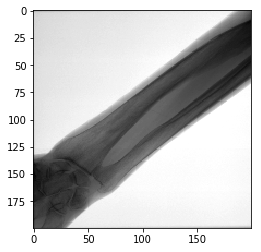

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


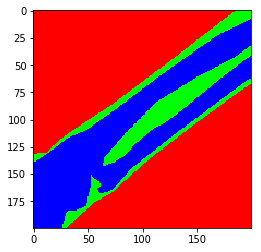

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


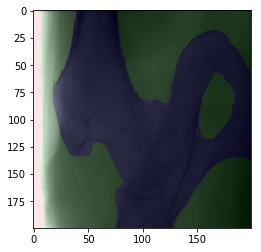

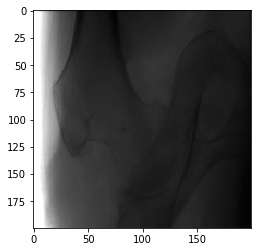

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


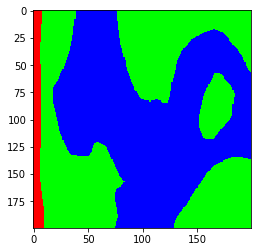

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


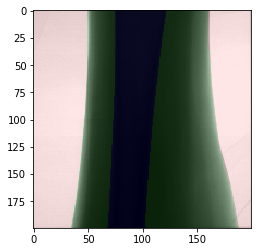

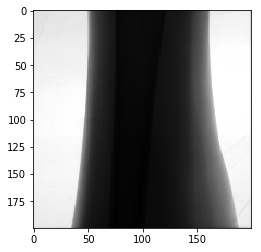

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


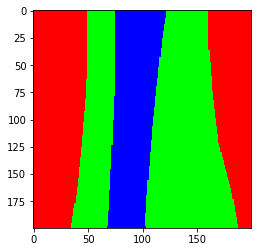

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


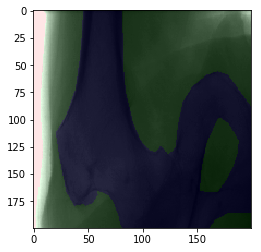

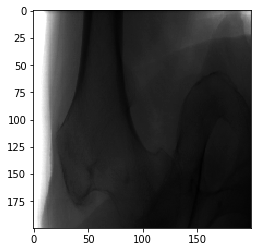

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


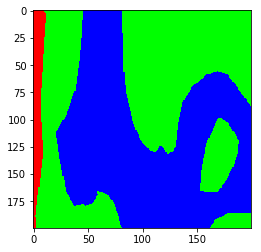

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


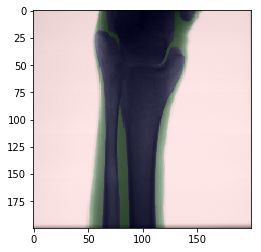

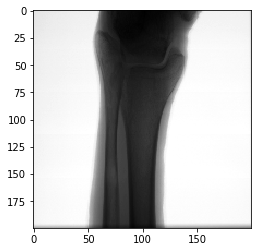

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


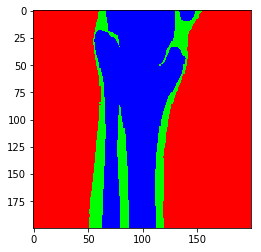

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


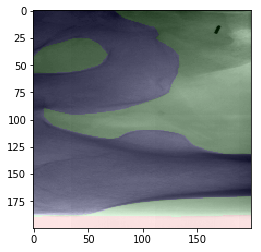

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


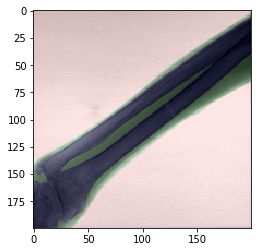

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


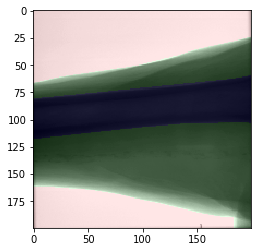

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


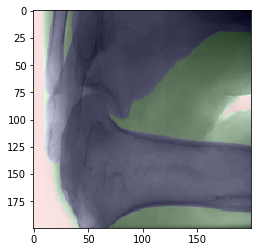

ValueError: Index (4) out of range (0-3)

In [9]:
n =  10

for i in range(n):
    plt.imshow(dataset['train_img'][i,...,0],cmap='gray')
    plt.imshow(dataset['train_label'][i,...],alpha=0.1)
    plt.show()
    plt.imshow(dataset['train_img'][i,...,0],cmap='gray')
    plt.show()
    plt.imshow(dataset['train_label'][i,...])
    plt.show()
    
for i in range(n):
    plt.imshow(dataset['val_img'][i,...,0],cmap='gray')
    plt.imshow(dataset['val_label'][i,...],alpha=0.1)
    plt.show()
for i in range(n):
    plt.imshow(dataset['test_img'][i,...,0],cmap='gray')
    plt.imshow(dataset['test_label'][i,...],alpha=0.1)
    plt.show()

# Features

In [23]:

def RandomGaussian(image,sigma=2.):
    ftg = skifilters.gaussian(image,sigma)
    #return np.reshape(ftg, (image.shape[0]*image.shape[1]*3))
    return ftg

def Laplacian(image):
    ftl = skifilters.laplace(image)
    #return np.reshape(ftl, (image.shape[0]*image.shape[1]*3))   
    return ftl

def HOG(image,orientations=8, pixels_per_cell=4, cells_per_block=1):
    fd, hog_image = skimage.feature.hog(image, orientations=orientations, pixels_per_cell=(pixels_per_cell, \
                    pixels_per_cell),cells_per_block=(cells_per_block, cells_per_block),visualise=True)
    return fd,hog_image

def canny(image, sigma=2., lthres=None, hthres=None):
    fc = skimage.feature.canny(image, sigma=1.0, low_threshold=None, high_threshold=None,\
                      mask=None, use_quantiles=False)
    return fc

def structure_tensor(image, sigma=2.):
    Axx, Axy, Ayy = skimage.feature.structure_tensor(image, sigma=sigma)
    eig = skimage.feature.structure_tensor_eigvals(Axx, Axy, Ayy)[0]
    return eig

def hessian(image,sigma=2.):
    # RETURNS ALL THE COMPONNETS! keep only last?
    fhess = skimage.feature.hessian_matrix(image, sigma=sigma, mode='constant', cval=0,order='xy')
    return fhess[-1]

def harris(image):
    # DOESN'T LOOK VERY PROMISING
    fharris = skimage.feature.corner_harris(image, method='k', k=0.5, eps=1e-08, sigma=2)
    return fharris

def median(image):
    fmed = skimage.filters.median(image, selem=None, out=None, mask=None, shift_x=False, shift_y=False)
    return fmed

def sobel(image):
    fsob = skimage.filters.sobel(image, mask=None)
    return fsob

def gabor(image):
    # Returns complex and imaginary
    fthres =  skimage.filters.gabor(image, frequency=0.6)
    return fthres
def log(image,sigma=1.):
    flog = scipy.ndimage.gaussian_laplace(image, sigma, output=None, mode='reflect')
    return flog
def gaussian_derivative(image, sigma=1, order=1):
    fdg = scifilters.gaussian_filter(image, sigma=1, order=1, output=None, mode='reflect', cval=0.0, truncate=4.0)
    return fdg

filters_list = ['image','gaussian_1', 'gaussian_2','gaussian_4','HOG','lapofgauss_1','lapofgauss_2','lapofgauss_4',\
           'lapofgauss_8','gaussian_derivative_2','gaussian_derivative_4']

def apply_filters(x,y,images,labels,n_features):
    for i in range(images.shape[0]):
        pixel_init = i*dataset.attrs['image_size']*dataset.attrs['image_size']
        pixel_final = (i+1)*dataset.attrs['image_size']*dataset.attrs['image_size']
        x[pixel_init:pixel_final,0] = images[i,...,0].flatten()
        x[pixel_init:pixel_final,1] = RandomGaussian(images[i,...,0],1.).flatten()
        x[pixel_init:pixel_final,2] = RandomGaussian(images[i,...,0],2.).flatten()
        x[pixel_init:pixel_final,3] = RandomGaussian(images[i,...,0],4.).flatten()
        x[pixel_init:pixel_final,4] = HOG(images[i,...,0])[1].flatten()
        x[pixel_init:pixel_final,5] = log(images[i,...,0],1.).flatten()
        x[pixel_init:pixel_final,6] = log(images[i,...,0],2.).flatten()
        x[pixel_init:pixel_final,7] = log(images[i,...,0],4.).flatten()
        x[pixel_init:pixel_final,8] = log(images[i,...,0],8.).flatten()
        x[pixel_init:pixel_final,9] = gaussian_derivative(images[i,...,0],2.).flatten()
        x[pixel_init:pixel_final,10] = gaussian_derivative(images[i,...,0],4.).flatten()

        y[pixel_init:pixel_final] = np.argmax(labels[i], axis=2, out=None).flatten()
    # Visualize filters
    for k in range(x.shape[1]):
        print(filters_list[k])
        plt.imshow(np.reshape(x[0:images.shape[1]*images.shape[1],k],(images.shape[1],images.shape[1])),cmap='gray')
        plt.show()
    return x,y

In [24]:
print(x.shape[1])

11


# Create input for random forest

c:\program files\python36\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


image


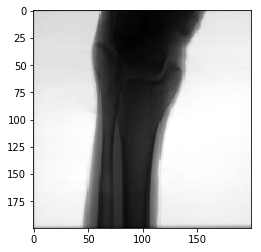

gaussian_1


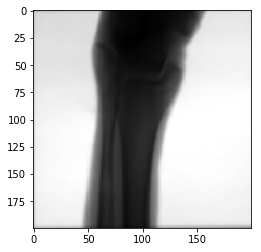

gaussian_2


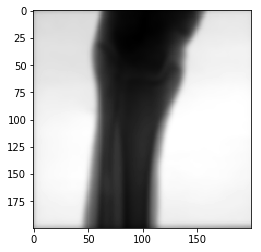

gaussian_4


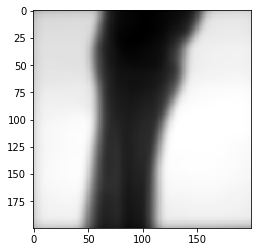

HOG


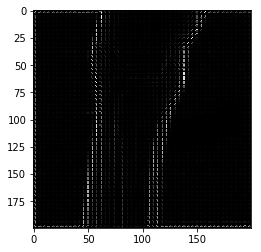

lapofgauss_1


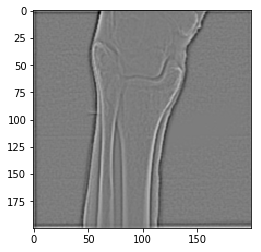

lapofgauss_2


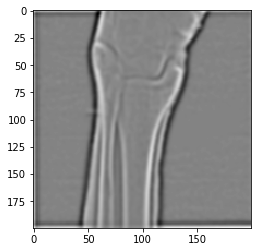

lapofgauss_4


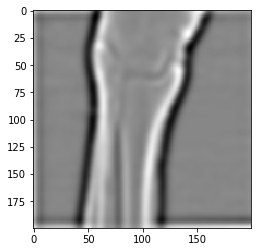

lapofgauss_8


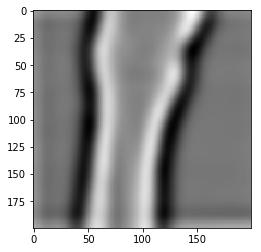

gaussian_derivative_2


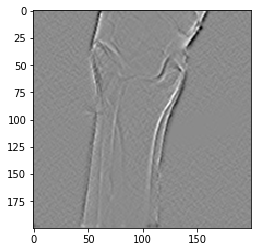

gaussian_derivative_4


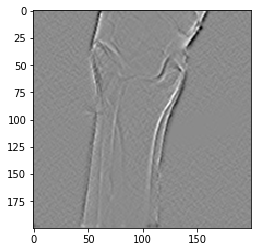

In [25]:
# Input data must has shape [n_samples, n_features]
n_features = len(filters_list) 
n_images = dataset['train_img'].shape[0]

x = np.empty((n_images*dataset.attrs['image_size']*dataset.attrs['image_size'], n_features))
# +1 for the actual image
y = np.empty((n_images*dataset.attrs['image_size']*dataset.attrs['image_size']))

x, y = apply_filters(x,y,dataset['train_img'], dataset['train_label'],n_features)


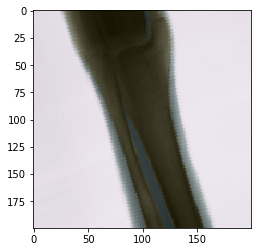

In [9]:
index_show = 203
plt.imshow(np.reshape(x[200*200*index_show:200*200*(index_show+1),0],(200,200)),cmap='gray')
plt.imshow(np.reshape(y[200*200*index_show:200*200*(index_show+1)],(200,200)),alpha=0.1)


c:\program files\python36\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


image


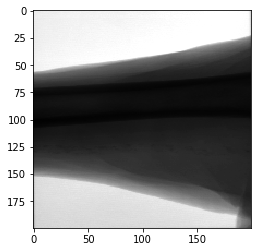

gaussian_1


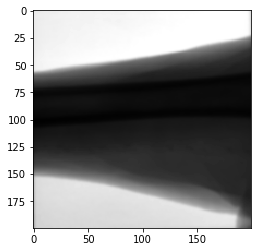

gaussian_2


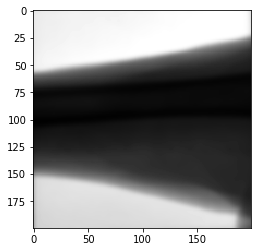

gaussian_4


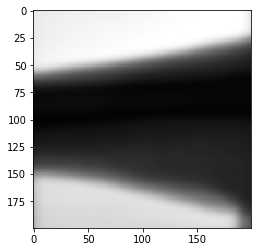

HOG


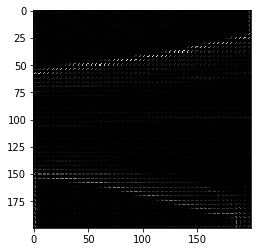

lapofgauss_1


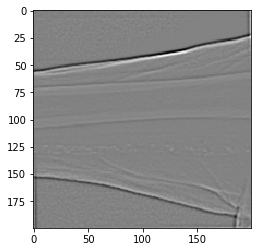

lapofgauss_2


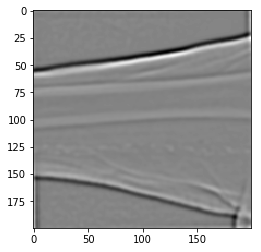

lapofgauss_4


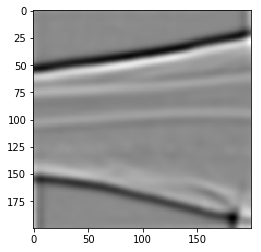

lapofgauss_8


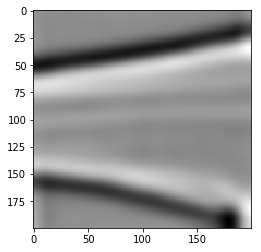

gaussian_derivative_2


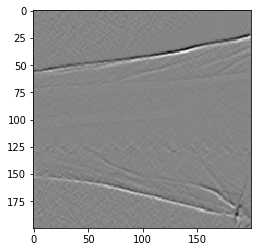

gaussian_derivative_4


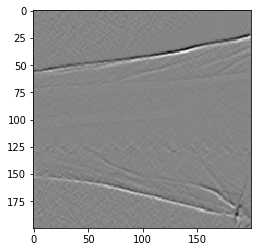

In [30]:
n_test= dataset['test_img'].shape[0]

test_x = np.empty((n_test*dataset.attrs['image_size']*dataset.attrs['image_size'], n_features))
test_y = np.empty((n_test*dataset.attrs['image_size']*dataset.attrs['image_size']))
test_x, test_y = apply_filters(test_x,test_y,dataset['test_img'], dataset['test_label'],n_features)

# Train a random forest classifier

In [ ]:
RF = RandomForestClassifier(verbose=1,n_estimators=1000, min_samples_leaf=50,n_jobs=3,oob_score=True)

RF.fit(x,y)

In [ ]:
train_accuracy = RF.score(x,y)

In [ ]:
test_accuracy = RF.score(test_x,test_y)

In [ ]:
print('Training acuracy :  %f' %train_accuracy)
print('Test acuracy :  %f' %test_accuracy)

In [ ]:
std = np.std([tree.feature_importances_ for tree in RF.estimators_],
             axis=0)
print(std)

In [ ]:
importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
 
for f in range(x.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, filters_list[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), indices)
plt.xlim([-1, x.shape[1]])
plt.show()

In [39]:
prediction = RF.predict(test_x)

[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.4s finished


In [40]:
print(prediction.shape)

(120000,)


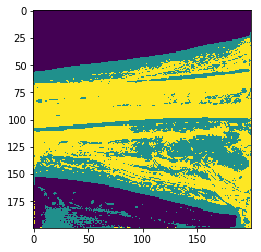

In [47]:
index_show = 0
plt.imshow(np.reshape(prediction[200*200*index_show:200*200*(index_show+1)],(200,200)))
#plt.imshow(np.reshape(prediction,(200,200)),alpha=0.3)